# Tooploox Data Science Intern - Cifar10 project

## PART I - Shallow classifier

### Introduction
The aim of this project is to appropriately preprocess the Cifat10 image data and select the most suitable learning methods for image classification. In this notebook we extract features using the "standard" image processing methods and then we use SVM to train the baseline classiffier.
This will be later used to compare with the results from the analysis which uses features produced by the last layer of the CNN Incepction v3 architecture.

In [2]:
# Importing required packages
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import os
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

random_state = 42

I collected several useful functions for the purpose of the project, They are saved in 3 different Python files.

In [3]:
# Importing custom functions for the project
from downloadANDload import *
from plot_functions import *
from feature_extraction import *

I am using different virtual enviroments in this project. This is because some libraries are only supported with Python 2 version, while others with Python 3. Here, I am making sure, which Python version I am currently using.

In [4]:
import sys
print("Check Python version")
sys.version

Check Python version


'3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

Now, we need to download and extract the Cifar10 data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz. The files will be extracted in the folder "cifar-10-batches-py" which is in the project directory.

In [10]:
download_and_open() 

dataset_path = "/home/kyp/tooploox/MyProject/cifar-10-batches-py/"


Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.



There are 8 files extracted from the "cifar-10-python.tar.gz" file, icluding 5 batches of the training images, 1 batch with the test images, 1 batch with dataset information and readme file. We load training images and corresponding labels first.

In [11]:
images_train_full, labels_train_full = load_training_set(dataset_path)

Loading: data_batch_1
Loading: data_batch_2
Loading: data_batch_3
Loading: data_batch_4
Loading: data_batch_5


In [12]:
images_test, labels_test = load_test_set(dataset_path)

Loading: test_batch


In [20]:
print("Its always good to know the shape of the data.")
print("Shape of loaded data:\n images_train_full: {},\n images_test: {},\n labels_train_full: {},\n labels_test: {} "
      .format(images_train_full.shape,images_test.shape, labels_train_full.shape,labels_test.shape))

Its always good to know the shape of the data.
Shape of loaded data:
 images_train_full: (50000, 32, 32, 3),
 images_test: (10000, 32, 32, 3),
 labels_train_full: (50000,),
 labels_test: (10000,) 


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

The images are 32x32 pixels, where each pixel is described by 3 (red,blue,green) color parameters.
Class labels are loaded from the batch.meta file and are as follows:

In [21]:
class_names = load_class_names()
print(class_names)
print("Number of classes: {}".format(len(class_names)))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10


# Plot example images

Now we want to display random images from the dataset, 10 per each class. For this purpose, we will use the function stored in plot_function.py file, but firs we generate the list of 100 random images, 10 per each class. 

In [35]:
# Generate the list of 100 random images, 10 per each class
num_classes = 10
idxs = []
for i in range(num_classes):
    # Create a list of indexes in the training set per each class and choose 10 at random 
    class_idxs = np.where(labels_train_full[:]==i)[0]
    class_idxs_random = class_idxs[np.random.randint(len(class_idxs),size=10)]
    idxs.extend(class_idxs_random)

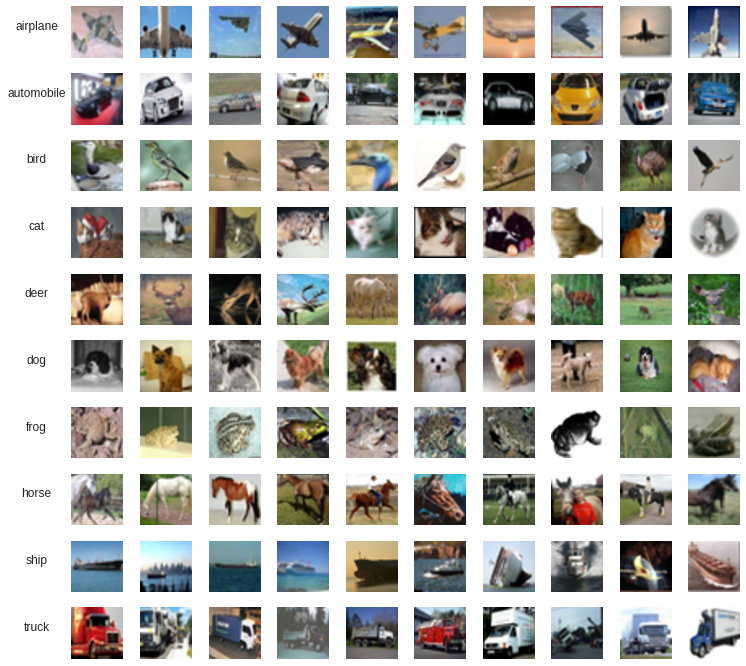

In [36]:
# Get the random images from the training set.
images_rand = images_train_full[idxs]
# Get the true classes for those images.
cls_true = labels_train_full[idxs]
# Plot the images and labels using helper-function above.
plot_images(images=images_rand, cls_true=cls_true, class_names = class_names, smooth=True)

# Validation split

In order to make a choice of the final classification algorithm I am going to try several different models with different hyperparameter settings. The test will be used for the estimation of generalisation performance, hence we can't use it for model selection, as this would be inherently wrong. 


We need the validation set which will be used for choosing the model for final training. For this reason we take a small piece of the training set (20%) and keep it for each initial model evaluation.

In [22]:
# Create hold-out validation set
images_train, images_valid, labels_train, labels_valid = train_test_split(images_train_full, labels_train_full, 
                                                  test_size=0.2, random_state=random_state)

In [23]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Validation-set:\t\t{}".format(len(images_valid)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		40000
- Validation-set:		10000
- Test-set:		10000


## Classifier on raw data
Before extracting features I am tempted to run algorithm of the pure pixel data (flattened) and "see what happens". To save time I will use Stochastic Gradient Descent classifier.

In [33]:
# Preprocessing: reshape the image data into rows
X_tr_pix = np.reshape(images_train_full, (images_train_full.shape[0], -1))
X_tst_pix = np.reshape(images_test, (images_test.shape[0], -1))
print(X_tr_pix.shape,X_tst_pix.shape )

(50000, 3072) (10000, 3072)


In [36]:
%%time
# Optimizing hyperparameters in SGD
clfSGD = SGDClassifier(random_state=random_state)
clfSGD.fit(X_tr_pix, labels_train_full)
print("Classification accuracy on test set: {:.3f}".format(clfSGD.score(X_tst_pix,labels_test)))
print()
print("Training size: {}".format( len(X_tr_pix)))

Classification accuracy on test set: 0.293

Training size: 50000
CPU times: user 8.42 s, sys: 4 ms, total: 8.42 s
Wall time: 8.33 s


# Feature extraction

We store different feature extraction methods in the feature_extracion.py file. We use modified version of skimage.feature.hog image descriptor and color histogram function as feature extractors. The code was adapted from https://github.com/huyouare/CS231n/blob/master/assignment1/cs231n/features.py .The reason to use this is simply because it works better on validation set than standard HoG features.

The final feature vector for each image is formed by concatenating
the HOG and color histogram feature vectors.

In [24]:
# Select feature extraction methods
feature_extracion_methods = [hog_features_custom,color_histogram_hsv]

# Extract features using selected methods
X_train_fts = extract_features(images_train, feature_extracion_methods, verbose=True)
X_valid_fts = extract_features(images_valid, feature_extracion_methods, verbose=True)
X_test_fts = extract_features(images_test, feature_extracion_methods, verbose=True)

Done extracting features for 1000 / 40000 images
Done extracting features for 2000 / 40000 images
Done extracting features for 3000 / 40000 images
Done extracting features for 4000 / 40000 images
Done extracting features for 5000 / 40000 images
Done extracting features for 6000 / 40000 images
Done extracting features for 7000 / 40000 images
Done extracting features for 8000 / 40000 images
Done extracting features for 9000 / 40000 images
Done extracting features for 10000 / 40000 images
Done extracting features for 11000 / 40000 images
Done extracting features for 12000 / 40000 images
Done extracting features for 13000 / 40000 images
Done extracting features for 14000 / 40000 images
Done extracting features for 15000 / 40000 images
Done extracting features for 16000 / 40000 images
Done extracting features for 17000 / 40000 images
Done extracting features for 18000 / 40000 images
Done extracting features for 19000 / 40000 images
Done extracting features for 20000 / 40000 images
Done extr

# Initial training and hyperparameter optimisation 

#### Now we want to experiment with different classifiers and parameters settings to train the best classiffier. 

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [28]:
# Stardardise to 0 mean and unit variance
sc = StandardScaler().fit(X_train_fts)
X_train = sc.transform(X_train_fts)
X_valid = sc.transform(X_valid_fts)
y_train = labels_train
y_valid = labels_valid
# Initialise CV folds
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)

I was cutting the size of the training set for the 

In [29]:
# I was performing initial experiments with smaller training sets
N = 4000
X_tr = X_train#[:N]
y_tr = y_train#[:N]

In [ ]:
print("Shape of extracted feature matrices:\n X_train: {},\n X_valid:{},\n X_test: {},\n y_train: {},\n y_valid: {},\n y_test: {} "
      .format(X_train.shape,X_valid.shape,X_test.shape, y_train.shape, y_valid.shape,y_test.shape))

### LinearSVC

In [30]:
# Optimizing hyperparameters in LinearSVC
clf = LinearSVC(random_state=random_state)

# Set the parameters by cross-validation
parameter_space = {'C': np.logspace(-3,2,6)}
k = 3

lsvc_clf = GridSearchCV(clf, parameter_space,n_jobs = -1 , cv=k, scoring='accuracy')
lsvc_clf.fit(X_tr, y_tr)

##########################################################################
#############REPORT#######################################################
##########################################################################
print("# Tuning hyper-parameters for accuracy")
print()
print("Best parameters set found on development set:")
print()
print(lsvc_clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in lsvc_clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print("Best cross-validated score: {:.3f}".format(lsvc_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(lsvc_clf.score(X_valid,y_valid)))

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 0.10000000000000001}

Grid scores on development set:

0.496 (+/-0.003) for {'C': 0.001}
0.498 (+/-0.002) for {'C': 0.01}
0.498 (+/-0.001) for {'C': 0.10000000000000001}
0.496 (+/-0.003) for {'C': 1.0}
0.378 (+/-0.010) for {'C': 10.0}
0.314 (+/-0.030) for {'C': 100.0}
Best cross-validated score: 0.498
Classification accuracy on validation set: 0.504


/home/kyp/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### SVC with different kernels

In [63]:
svc = SVC()
parameters = [{'kernel': ['linear'], 'C': [0.001, 0.01,0.1, 1]},
                    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [0.1, 1, 10, 100]}]

svc_clf3 = GridSearchCV(estimator=svc, cv=cv,n_jobs = -1, param_grid=parameters, scoring='accuracy')
svc_clf3.fit(X_tr, y_tr)

for params, mean_score, scores in svc_clf3.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

print("Best parameters for SVC with RBF kernel, C: {}, gamma: {}".
      format(svc_clf3.best_params_["C"], svc_clf3.best_params_["gamma"]))
print()
print("Best cross-validated score: {}".
      format(svc_clf3.best_score_))
print()
print("Classification accuracy on validation set: {:.3f}".format(svc_clf3.score(X_valid,y_valid)))


/home/kyp/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.507 (+/-0.009) for {'C': 0.001, 'kernel': 'linear'}
0.514 (+/-0.009) for {'C': 0.01, 'kernel': 'linear'}
0.511 (+/-0.006) for {'C': 0.1, 'kernel': 'linear'}
0.510 (+/-0.007) for {'C': 1, 'kernel': 'linear'}
0.496 (+/-0.012) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.298 (+/-0.030) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.535 (+/-0.010) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.491 (+/-0.012) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.570 (+/-0.008) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.518 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.579 (+/-0.011) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.532 (+/-0.010) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best parameters for SVC with RBF kernel, C: 100, gamma: 0.001

Best cross-validated score: 0.5789

Classification accuracy on validation set: 0.592


In [65]:
print("Best parameters for SVC ,kernel: {}. C: {}, gamma: {}".
      format(svc_clf3.best_params_["kernel"],svc_clf3.best_params_["C"], svc_clf3.best_params_["gamma"]))
print()
print("Best cross-validated score: {}".
      format(svc_clf3.best_score_))
print()
print("Classification accuracy on validation set: {:.3f}".format(svc_clf3.score(X_valid,y_valid)))

Best parameters for SVC ,kernel: rbf. C: 100, gamma: 0.001

Best cross-validated score: 0.5789

Classification accuracy on validation set: 0.592


# Final training
##### So the best model is SVC with rbf kernel. Let's train it on the full set and see what is the score on the previously unseen data.

In [68]:
# Make the full set for final training
X_train_full = np.concatenate((X_train_fts, X_valid_fts), axis=0)
y_train_full = np.concatenate((y_train, y_valid), axis=0)
X_test = X_test_fts
print(X_train_full.shape, X_test.shape, y_train_full.shape)

(50000, 154) (10000, 154) (50000,)


In [69]:
sc = StandardScaler().fit(X_train_full)
X_train_full = sc.transform(X_train_full)
X_test = sc.transform(X_test)

In [70]:
# Train on the full training set using best classifier with best parameters
clf = SVC(kernel='rbf',C=100,gamma=0.001, random_state=random_state)
clf.fit(X_train_full, y_train_full)

# Build-in score method
test_score = clf.score(X_test, y_test)

# By using the predict() method and accuracy_score metric
clf_prediction = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, clf_prediction)

In [71]:
print("Final classification accuracy on test set: {:.3f}".format(clf_accuracy))

Final classification accuracy on test set: 0.599


#### Confusion Matrix
We can have a look at the confusion matrix now to see which classes are easiest to predict and which are hardest. Also we can see which classes are most similar to each other (according to computer).

In [73]:
cm = confusion_matrix(y_test, clf_prediction)
print('Confusion matrix\n{}'.format(cm))

Confusion matrix
[[695  23  52  23  25  13   9   6 120  34]
 [ 39 710  12  21  12   9  12  14  63 108]
 [100   9 476  72 125  81  74  34  20   9]
 [ 39  26  99 440  88 127  88  54  13  26]
 [ 35  16 108  76 553  45  75  61  23   8]
 [ 25  10 120 184  80 430  71  58  17   5]
 [ 22  15  78  80  79  47 657  14   5   3]
 [ 20  20  46  80  76  80  25 613  11  29]
 [105  64  21  16  14   3  10   7 728  32]
 [ 40 121  17  28  10  16   6  28  46 688]]


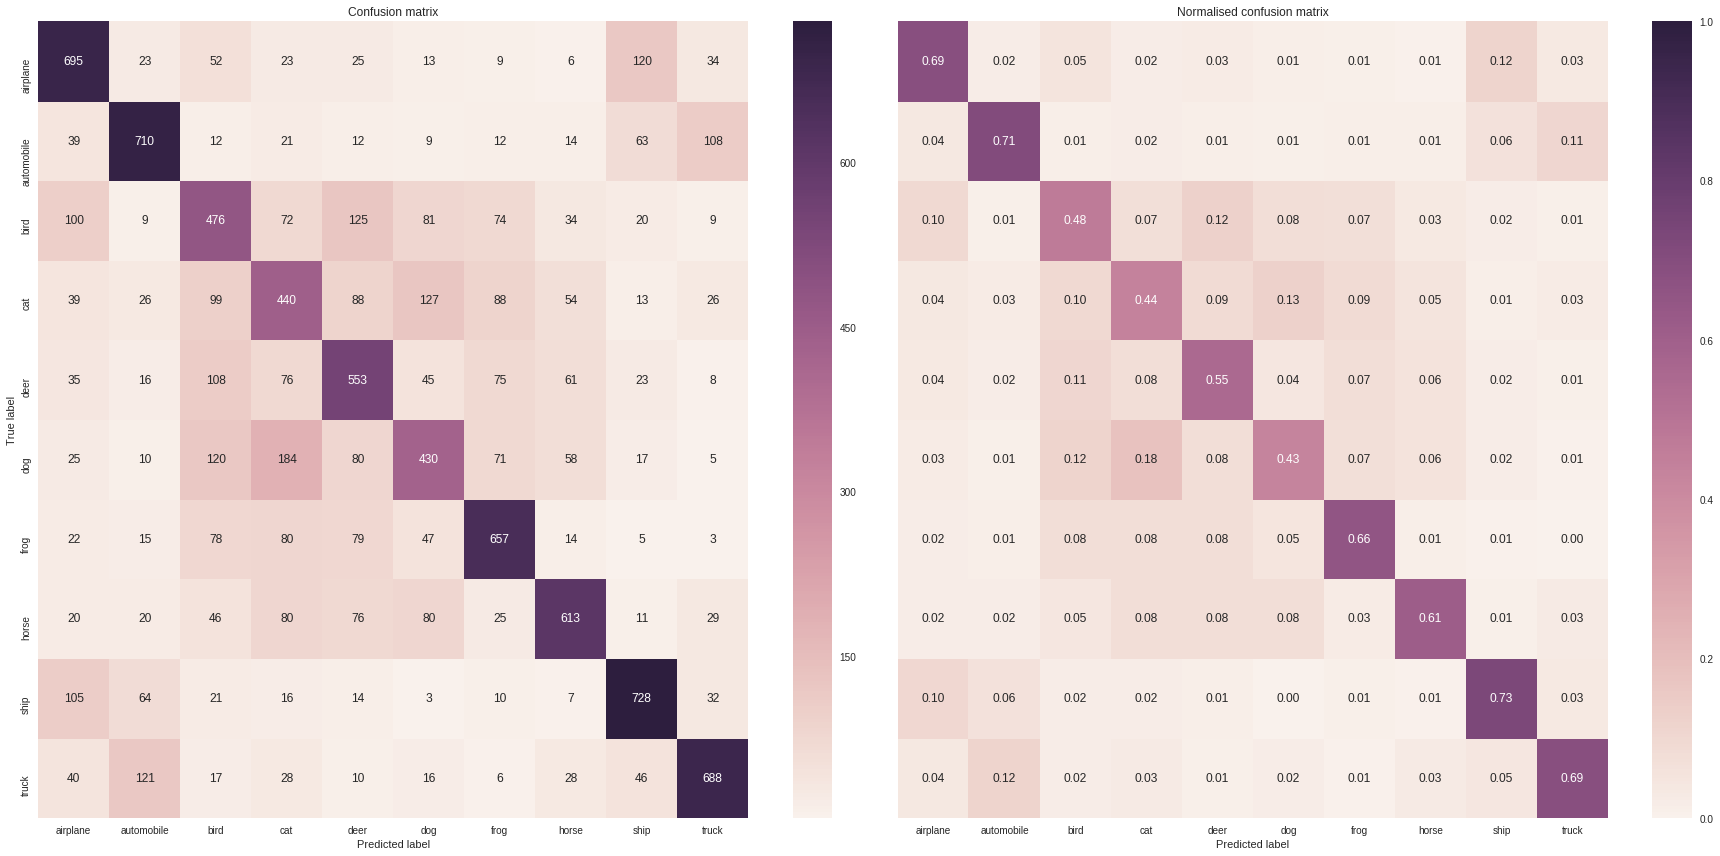

In [76]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(121)
plot_confusion_matrix(cm, normalize=False, classes=class_names) # un-normalized
ax2 = fig.add_subplot(122)
plot_confusion_matrix(cm, normalize=True, classes=class_names, title='Normalised confusion matrix') # normalized
ax2.get_yaxis().set_visible(False)
fig.tight_layout()

To see better I recomend opening confusion matrix above in the new window. We can see that cats are confused with dogs, planes with birds and ships, cars with trucks ect. Its all quite intuitive I think...

#### Missclassification examples

It will be interesting to see where our classifier makes mistakes...

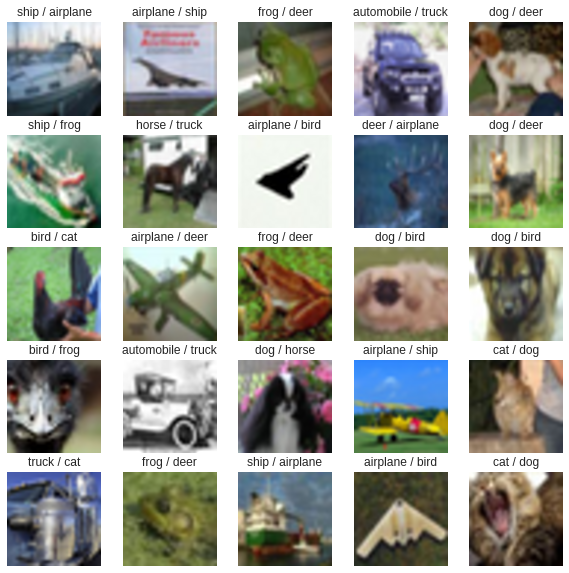

In [106]:
# Examples of missclassifications
wrong = np.where(y_test != clf_prediction)[0] 

fig = plt.figure(figsize=(10,10))
for i in range(25):
    fig.add_subplot(5,5,(i+1),xticks=[], yticks=[])
    idx = wrong[i]
    plt.title("{} / {}".format(class_names[y_test[idx]], class_names[clf_prediction[idx]]))
    # Plot image.
    plt.imshow(images_test[idx, :, :, :],interpolation = 'spline16')
    
plt.savefig('/home/kyp/tooploox/MyProject/cifar-10-batches-py/cifar_misclassified.jpg')